In [11]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

import geom2d as g
import numpy as np
import numba as nb

In [13]:


@nb.njit
def line2circle(v1, p0, c, r):
    v1_orth = np.array([v1[1], -v1[0]])
    c1 = g.dot(v1_orth, p0)
    c2 = g.dot(v1, c)

    rintersection = g.solve(v1_orth, v1, c1, c2)
    rvec = rintersection - c
    rlen2 = g.norm2(rvec)
    if rlen2 > r**2:
        intersection1 = np.array([np.nan, np.nan])
        intersection2 = np.array([np.nan, np.nan])
    else:
        offset = np.sqrt(r**2 - rlen2)

        intersection1 = rintersection + offset * v1
        intersection2 = rintersection - offset * v1

    # print(f"Intersections: {intersection1}, {intersection2}")
    # print(f"Intersection distance: {g.norm(intersection1-c)}, {g.norm(intersection2-c)}")
    return intersection1, intersection2

v1 = np.array([1, 0])

p0 = np.array([0, 0])
c = np.array([1, -1])
r = 1.1

@nb.njit
def test(N=1000):


    out = np.empty((N, 2, 2))

    for i in range(N):
        intersection1, intersection2 = line2circle(v1, p0, c, r)
        out[i, 0, :] = intersection1
        out[i, 1, :] = intersection2

N = int(1e6)
test(1000)
%timeit test(N)

93.8 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
def line2circle_np(v1, p0, c, r):
    v1_orth = v1 @ np.array([[0, -1], [1, 0]])
    c1 = (v1_orth * p0).sum(axis=-1, keepdims=True)
    c2 = (v1 * c).sum(axis=-1, keepdims=True)

    rintersection = np.linalg.solve(np.stack((v1_orth, v1), axis=1), np.stack((c1, c2), axis=1))[:, :, 0]
    rvec = rintersection - c
    rlen2 = (rvec * rvec).sum(axis=-1, keepdims=True)
    rlen2 = np.ma.masked_where(rlen2 > r**2, rlen2)

    offset = np.sqrt(r**2 - rlen2)

    intersection1 = rintersection + offset * v1
    intersection2 = rintersection - offset * v1

    np.ma.filled(intersection1, np.nan)
    np.ma.filled(intersection2, np.nan)

    # print(f"Intersections: {intersection1}, {intersection2}")
    # print(f"Intersection distance: {g.norm(intersection1-c)}, {g.norm(intersection2-c)}")
    return intersection1, intersection2


v1_np = np.repeat(v1[np.newaxis, :], N, axis=0)
p0_np = np.repeat(p0[np.newaxis, :], N, axis=0)
c_np = np.repeat(c[np.newaxis, :], N, axis=0)
r_np = np.repeat([[r]], N, axis=0)

%timeit line2circle_np(v1_np, p0_np, c_np, r_np)

202 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
@nb.njit
def calc_circle_normals(p0, p1, bulge):
    v = p1 - p0
    cl = g.norm(v)
    b = bulge[i] * cl
    radius = (cl**2/4 + b**2)/(2*b)
    vhat = v / cl
    normal = np.array([-vhat[1], vhat[0]])
    midpoint = 0.5 * (p0 + p1)
    center = midpoint - normal * (radius - b)
    n0 = p0 - center
    n0 = n0 / g.norm(n0)
    n1 = p1 - center
    n1 = n1 / g.norm(n1)
    return n0, n1

@nb.njit
def calc_line_normals(p0, p1):
    v = p1 - p0
    v = v / g.norm(v)
    return np.array([-v[1], v[0]]), np.array([-v[1], v[0]])

@nb.njit
def calc_norms(p0, p1, bulge, n0, n1):
    for i in range(len(p0)):
        if bulge[i] == 0:
            a, b = calc_line_normals(p0[i], p1[i])
            n0[i] = a
            n1[i] = b
        else:
            a, b = calc_circle_normals(p0[i], p1[i], bulge[i])
            n0[i] = a
            n1[i] = b


class Path:
    def __init__(self, p0, p1, bulge):
        self.num_points = 0
        self.p0 = p0
        self.p1 = p1
        self.c = np.empty_like(p0)
        self.r = np.empty(p0.shape[0], 1)
        self.tstart = np.empty(p0.shape[0], 1)
        self.tdelta = np.empty(p0.shape[0], 1)

    def calc_norms(self):
        calc_norms(self.p0, self.p1, self.bulge, self.n0, self.n1)

    def offset(self, offset):
        p0_new = np.empty_like(self.p0)
        p1_new = np.empty_like(self.p1)
        bulge_new = np.empty_like(self.bulge)
        for i in range(self.p0.shape[0]):
            p0_new[i] = self.p0[i] + offset * self.n0[0]
            p1_new[i] = self.p1[i] + offset * self.n1[0]
            if self.bulge[i] != 0:
                self.bulge_new[i] = 

@nb.njit
def getCircleIntersectionSolution(p0_arr, p1_arr, bulge_arr, i):


@nb.njit
def offset(p0_arr, p1_arr, bulge_arr, i, offset):
    """Compute the offset of a line segment (p0, p1) by a bulge value.

    Args:
        p0 (np.ndarray): Starting point of the line segment.
        p1 (np.ndarray): Ending point of the line segment.
        bulge (float): Bulge value.

    Returns:
        np.ndarray: Offset point.
    """

    v = np.empty_like(1, 2)
    n_prev = np.empty_like(1, 2)
    c_prev = np.empty_like(1, 2)    
    r_prev = 0
    dphase_prev = 0
    n_prev =
    if bulge_arr[0] != 0:
        c_prev, r_prev, phase0_prev, dphase_prev = g.bulge2arc(p0_arr[0], p1_arr[0], bulge_arr[0])
    else:
        

    for i in range(p0_arr.shape[0]):
        pass


IndentationError: expected an indented block after 'else' statement on line 56 (2732910131.py, line 60)

Line data: [[ 0.  0.  9.  0.]
 [10.  1. 10.  4.]
 [ 9.  5.  0.  5.]
 [-1.  4. -1.  1.]]
Arc data: [[-1.11022302e-16  1.00000000e+00 -1.00000000e+00  6.28318531e+00
   1.57079633e+00]
 [ 9.00000000e+00  1.00000000e+00 -1.00000000e+00  7.85398163e+00
   1.57079633e+00]
 [ 9.00000000e+00  4.00000000e+00 -1.00000000e+00  3.14159265e+00
   1.57079633e+00]
 [-1.11022302e-16  4.00000000e+00 -1.00000000e+00  4.71238898e+00
   1.57079633e+00]]
Segment info: [[0 0]
 [1 1]
 [0 1]
 [1 2]
 [0 2]
 [1 3]
 [0 3]
 [1 0]]


(4, 4)

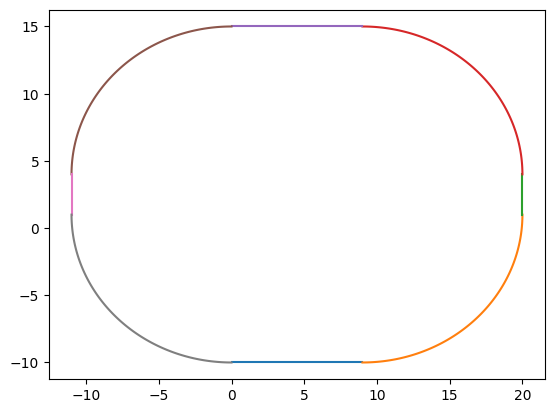

In [23]:
@nb.njit
def line_intersect_arc(lineData, arcData, lineIndex, arcIndex, reverse=False):
    p0_line = lineData[lineIndex, 0:2]
    p1_line = lineData[lineIndex, 2:4]

    c = arcData[arcIndex, 0:2]
    r = arcData[arcIndex, 2]
    phase0 = arcData[arcIndex, 3]
    dphase = arcData[arcIndex, 4]

    v_line = p1_line - p0_line
    v_line_hat = v_line / g.norm(v_line)
    n_line_hat = np.array([-v_line_hat[1], v_line_hat[0]])

    # Find midpoint of possible solutions
    s1 = g.dot(n_line_hat, p0_line)
    s2 = g.dot(v_line_hat, c)
    intersection = g.solve(n_line_hat, v_line_hat, s1, s2)
    a = g.norm(intersection - c)
    b = r**2 - a**2
    if np.abs(b) < 1e-10:
        b = 0
    if b < 0:
        # No intersection
        arcData[arcIndex, 4] = np.nan
        return
    b = b**0.5 # Distance from midpoint to solutions

    # Determine which solution to use
    if reverse:
        phase = phase0 + dphase
    else:
        phase = phase0
    varc = np.sign(r) * np.array([np.cos(phase), np.sin(phase)])
    side = g.cross(varc, n_line_hat) # Positive means it's the closest solution


    if side < 0:
        # Closest solution
        intersection = intersection - b * v_line_hat
    else:
        # Farthest solution
        intersection = intersection + b * v_line_hat

 
    # Find phase change
    varc_p = intersection-c
    varc_p = varc_p / g.norm(varc_p)
    if g.cross(varc, varc_p) > 0:
        # ccw rotation
        dphase_p = np.acos(g.dot(varc, varc_p))
    else:
        # cw rotation
        dphase_p = -np.acos(g.dot(varc, varc_p))

    # Record intersected point
    if reverse:
        arcData[arcIndex, 4] += dphase_p
        lineData[lineIndex, 0] = intersection[0]
        lineData[lineIndex, 1] = intersection[1]
    else:
        arcData[arcIndex, 3] += dphase_p
        arcData[arcIndex, 4] -= dphase_p
        lineData[lineIndex, 2] = intersection[0]
        lineData[lineIndex, 3] = intersection[1]
    

@nb.njit
def line_intersect_line(lineData, index0, index1, reverse=False):
    v0 = lineData[index0, 2:4] - lineData[index0, 0:2]
    v1 = lineData[index1, 2:4] - lineData[index1, 0:2]

    n0 = np.array([-v0[1], v0[0]])
    n1 = np.array([-v1[1], v1[0]])

    s0 = g.dot(n0, lineData[index0, 0:2])
    s1 = g.dot(n1, lineData[index1, 0:2])

    intersection = g.solve(n0, n1, s0, s1)

    if reverse:
        lineData[index0, 0:2] = intersection
        lineData[index1, 2:4] = intersection
    else:
        lineData[index0, 2:4] = intersection
        lineData[index1, 0:2] = intersection

@nb.njit
def arc_intersect_arc(arcData, index0, index1, reverse=False):
    c0 = arcData[index0, 0:2]
    r0 = arcData[index0, 2]
    phase00 = arcData[index0, 3]
    dphase0 = arcData[index0, 4]  

    c1 = arcData[index1, 0:2]
    r1 = arcData[index1, 2]
    phase10 = arcData[index1, 3]
    dphase1 = arcData[index1, 4]

    v10 = c1-c0
    chord_length2 = g.norm2(v10)
    chord_length = chord_length2**0.5
    v10_hat = v10 / chord_length
    n10_hat = np.array([-v10_hat[1], v10_hat[0]])

    mp_dist = (r0**2 - r1**2 + chord_length2) / (2*chord_length)
    midpoint = c0 + v10_hat * mp_dist

    if reverse:
        reference_solution = c0 + r0*np.array([np.cos(phase00), np.sin(phase00)])
    else:
        reference_solution = c1 + r1*np.array([np.cos(phase10), np.sin(phase10)])
    ref_vec0 = reference_solution - c0
    ref_vec0 = ref_vec0 / g.norm(ref_vec0)
    ref_vec1 = reference_solution - c1
    ref_vec1 = ref_vec1 / g.norm(ref_vec1)

    # midpoint = (c0 + c1) / 2
    dist = (r0**2 - mp_dist**2)**0.5
    if g.cross(v10_hat, ref_vec0) >= 0:
        # Top half solution
        interesection = midpoint + n10_hat * dist
    else:
        # Bottom half
        interesection = midpoint - n10_hat * dist
    
    sol_v0 = interesection - c0
    sol_v0_hat = sol_v0 / g.norm(sol_v0)
    sol_v1 = interesection - c1
    sol_v1_hat = interesection / g.norm(sol_v1)
    
    # Find phase delta
    if g.cross(ref_vec0, sol_v0_hat):
        phase_delta0 = np.acos(g.dot(ref_vec0, sol_v0_hat))
    else:
        phase_delta0 = -np.acos(g.dot(ref_vec0, sol_v0_hat))
    
    if g.cross(ref_vec1, sol_v1_hat):
        phase_delta1 = np.acos(g.dot(ref_vec1, sol_v1_hat))
    else:
        phase_delta1 = -np.acos(g.dot(ref_vec1, sol_v1_hat))

    # Update phase angles
    if reverse:
        arcData[index0, 3] += phase_delta0
        arcData[index0, 4] -= phase_delta0
        arcData[index1, 4] += phase_delta1
    else:
        arcData[index0, 4] += phase_delta0
        arcData[index1, 3] += phase_delta1
        arcData[index1, 4] -= phase_delta1


@nb.njit
def join(line_data, arc_data, segment_data):
    for i in range(segment_data.shape[0]):
        i2 = (i+1) % segment_data.shape[0]
        if segment_data[i, 0] == 0 and segment_data[i2, 0] == 0:
            # Line to Line
            line_intersect_line(line_data, segment_data[i, 1], segment_data[i2, 1])
        elif segment_data[i, 0] == 0 and segment_data[i2, 0] == 1:
            # Line to arc
            line_intersect_arc(line_data, arc_data, segment_data[i, 1], segment_data[i2, 1])
        elif segment_data[i, 0] == 1 and segment_data[i2, 0] == 0:
            # Arc to line
            line_intersect_arc(line_data, arc_data, segment_data[i2, 1], segment_data[i, 1], True)
        else:
            # Arc to arc
            arc_intersect_arc(arc_data, segment_data[i, 1], segment_data[i2, 1])

@nb.njit
def compact_to_segments(compact_path):
    num_segments = compact_path.shape[0]
    num_arcs = 0
    num_lines = 0
    arc_data = np.empty((num_segments, 5), dtype=np.float64)
    line_data = np.empty((num_segments, 4), dtype=np.float64)
    segment_info = np.empty((num_segments, 2), dtype=np.uint32)

    p0 = compact_path[-1, 0:2]
    b0 = compact_path[-1, 4]
    for i in range(num_segments):
        p1 = compact_path[i, 0:2]
        b1 = compact_path[i, 4]

        if b0 == 0:
            # Line segment
            line_data[num_lines, 0:2] = p0
            line_data[num_lines, 2:4] = p1
            segment_info[i-1] = [0, num_lines]
            num_lines += 1
        else:
            # Arc
            c, r, p0, dp = g.bulge2arc(p0, p1, b0)
            arc_data[num_arcs, 0:2] = c
            arc_data[num_arcs, 2] = r
            arc_data[num_arcs, 3] = p0
            arc_data[num_arcs, 4] = dp
            segment_info[i-1] = [1, num_arcs]
            num_arcs += 1
        
        p0 = p1
        b0 = b1
    
    arc_data = arc_data[:num_arcs, :]
    line_data = line_data[:num_lines, :]

    return line_data, arc_data, segment_info

line_data = np.array([
    [0, 0, 1, 0],
    [1, 1, 3, 1]
], dtype=float)
arc_data = np.array([
    [1, 1, 1.05, np.pi*3/2, np.pi/2]
], dtype=float)

# line_intersect_arc(line_data, arc_data, 0, 0)
# line_intersect_arc(line_data, arc_data, 1, 0, True)

@nb.njit
def test():
    line_data = np.array([
        [0, 0, 1, 0],
        [1, 1, 3, 1]
    ], dtype=np.float64)
    arc_data = np.array([
        [1, 1, 1.05, np.pi*3/2, np.pi/2]
    ], dtype=np.float64)
    for _ in range(1000):
        line_intersect_arc(line_data, arc_data, 0, 0, False)


# print(line_data)
# print(arc_data)
# test()




import matplotlib.pyplot as plt

def plot_path(line_data, arc_data, segment_info):
    for i in range(segment_info.shape[0]):
        if segment_info[i, 0] == 0:
            # Line
            plt.plot(line_data[segment_info[i, 1], [0, 2]], line_data[segment_info[i, 1], [1, 3]])
        else:
            # Arc
            c = arc_data[segment_info[i, 1], 0:2]
            r = arc_data[segment_info[i, 1], 2]
            phase0 = arc_data[segment_info[i, 1], 3]
            dphase = arc_data[segment_info[i, 1], 4]
            phase = np.linspace(phase0, phase0 + dphase, 100)
            x = c[0] + r * np.cos(phase)
            y = c[1] + r * np.sin(phase)
            plt.plot(x, y)

@nb.njit
def offset(line_data, arc_data, segment_info, distance):
    num_segments = segment_info.shape[0]
    for i in range(num_segments):
        if segment_info[i, 0] == 0:
            # Line
            p0 = line_data[segment_info[i, 1], 0:2]
            p1 = line_data[segment_info[i, 1], 2:4]
            v = p1 - p0
            v = v / g.norm(v)
            n = np.array([-v[1], v[0]])
            line_data[segment_info[i, 1], 0:2] += n * distance
            line_data[segment_info[i, 1], 2:4] += n * distance
        else:
            # Arc
            arc_data[segment_info[i, 1], 2] += distance

compact_data = np.array([
    [0, 0, 0, 0, 0],
    [9, 0, 0, 0, -0.5],
    [10, 1, 0, 0, 0],
    [10, 4, 0, 0, -0.5],
    [9, 5, 0, 0, 0],
    [0, 5, 0, 0, -0.5],
    [-1, 4, 0, 0, 0],
    [-1, 1, 0, 0, -0.5]
], dtype=np.float64)

line_data, arc_data, segment_info = compact_to_segments(compact_data)
print(f"Line data: {line_data}")
print(f"Arc data: {arc_data}")
print(f"Segment info: {segment_info}")

offset(line_data, arc_data, segment_info, -10)
join(line_data, arc_data, segment_info)

plot_path(line_data, arc_data, segment_info)
line_data.shape

# %timeit test()


Line data: [[ 0.  0.  9.  0.]
 [10.  1. 10.  4.]
 [ 9.  5.  0.  5.]
 [-1.  4. -1.  1.]]
Arc data: [[-1.00000000e+00  1.11022302e-16  1.00000000e+00  1.57079633e+00
  -1.57079633e+00]
 [ 9.00000000e+00  1.00000000e+00 -1.00000000e+00  7.85398163e+00
   1.57079633e+00]
 [ 9.00000000e+00  4.00000000e+00 -1.00000000e+00  3.14159265e+00
   1.57079633e+00]
 [-1.11022302e-16  4.00000000e+00 -1.00000000e+00  4.71238898e+00
   1.57079633e+00]]
Segment info: [[0 0]
 [1 1]
 [0 1]
 [1 2]
 [0 2]
 [1 3]
 [0 3]
 [1 0]]


(4, 4)

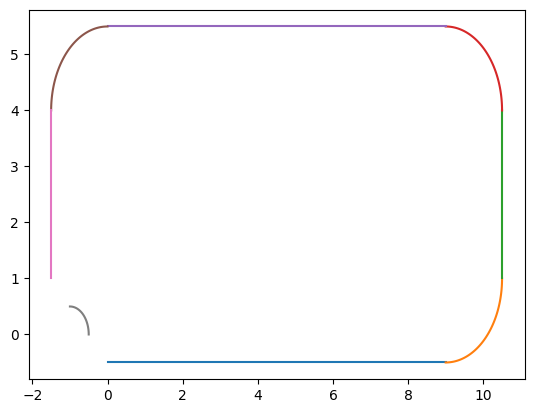

In [37]:
compact_data = np.array([
    [0, 0, 0, 0, 0],
    [9, 0, 0, 0, -0.5],
    [10, 1, 0, 0, 0],
    [10, 4, 0, 0, -0.5],
    [9, 5, 0, 0, 0],
    [0, 5, 0, 0, -0.5],
    [-1, 4, 0, 0, 0],
    [-1, 1, 0, 0, 0.5]
], dtype=np.float64)

line_data, arc_data, segment_info = compact_to_segments(compact_data)
print(f"Line data: {line_data}")
print(f"Arc data: {arc_data}")
print(f"Segment info: {segment_info}")

offset(line_data, arc_data, segment_info, -0.5)
# join(line_data, arc_data, segment_info)

plot_path(line_data, arc_data, segment_info)
line_data.shape